# Flights Delay Prediction ✈️ - Data Pre-Processing

This notebook focus on the pre-processing of data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Options
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
# Original
airlines_raw = pd.read_csv("data/airlines.csv")
airports_raw = pd.read_csv("data/airports.csv")
flights_train_raw = pd.read_csv("data/flights_train.csv")
flights_test_raw = pd.read_csv("data/flights_test.csv")
# Copies (work on the copies)
airlines = airlines_raw.copy()
airports = airports_raw.copy()
flights_train = flights_train_raw.copy()
flights_test = flights_test_raw.copy()

In [3]:
flights_train

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2818548,2015,6,30,2,UA,1180,N65832,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0
2818549,2818549,2015,6,30,2,UA,1192,N69839,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0
2818550,2818550,2015,6,30,2,UA,1480,N37298,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0
2818551,2818551,2015,6,30,2,UA,1637,N35260,SEA,IAH,2359,12.0,12.0,24.0,250.0,1874,609,9.0


In [6]:
def rearrange_date(df):
    """
    Merges YEAR, MONTH, DAY and puts it into a datetime object.
    Creates WEEK_DAY based on date.
    """
    # Create a Date Time Variable - YEAR-MONTH-DAY all in the same field - train
    df = df.astype({'YEAR': 'str', 'MONTH': 'str', 'DAY': 'str'})
    df["DATE"] = df["DAY"].str.cat(df[['MONTH', 'YEAR']], sep='-')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['WEEK_DAY'] = df['DATE'].dt.day_name()
    df.drop(columns = ['YEAR', 'MONTH', 'DAY'], inplace=True)
    return df

In [5]:
def departure_delay(day, scheduled_departure, departure, arrival_delay=None):
    '''
    Calculate the departure delay.
    Assumption: the delay is always positive unless the negative delay is less than 90 minutes.

    Input:
    date - date of the schedule departure. - datetime
    scheduled_departure - time (hhmm) for the scheduled departure. - int64
    departure - actual time (hhmm) for the departure. - float64
    '''
    # Transform to datetime objects
    scheduled_departure = "{0:04d}".format(int(scheduled_departure))
    scheduled_departure = day + datetime.timedelta(hours=int(scheduled_departure[0:2]),
                                                   minutes=int(scheduled_departure[2:4]))
    departure = "{0:04d}".format(int(departure))
    departure = datetime.timedelta(hours=int(departure[0:2]), minutes=int(departure[2:4]))

    # Create array with possible intervals
    previous_day = day - datetime.timedelta(days=1)
    previous_day_departure = previous_day + departure
    day_departure = day + departure
    next_day = day + datetime.timedelta(days=1)
    next_day_departure = next_day + departure
    time_differences = np.array([(previous_day_departure - scheduled_departure).total_seconds(),
                                 (day_departure - scheduled_departure).total_seconds(),
                                 (next_day_departure - scheduled_departure).total_seconds()]) / 60
    time_differences = time_differences[time_differences > -90]
    min_index = np.argmin(np.abs(time_differences))
    if arrival_delay:
        arrival_departure_difference = np.abs(arrival_delay - time_differences)
        min_index = np.argmin(arrival_departure_difference)
    # Get minimum interval
    return time_differences[min_index]

# Test function
departure_delay(datetime.datetime(2015, 1, 1), 1700, 1709)


9.0

In [62]:
def create_output(predictions): 
    print(np.arange(len(predictions)))
    print(np.reshape(predictions,(len(predictions))))
    submission = pd.DataFrame(data={"id": np.arange(len(predictions)),
                                    "ARRIVAL_DELAY": np.reshape(predictions,(len(predictions)))})
    return submission

In [7]:
# Create Date with Datetime obj 
flights_train = rearrange_date(flights_train)
flights_test = rearrange_date(flights_test)

# Calculate Departure Delay
flights_train["DEPARTURE_DELAY"] = flights_train.apply(lambda row: departure_delay(row["DATE"], row["SCHEDULED_DEPARTURE"], row["DEPARTURE_TIME"], arrival_delay=row["ARRIVAL_DELAY"]), axis=1)
flights_test["DEPARTURE_DELAY"] = flights_test.apply(lambda row: departure_delay(row["DATE"], row["SCHEDULED_DEPARTURE"], row["DEPARTURE_TIME"]), axis=1)


In [6]:
# Check Missing Values
flights_test.isna().sum(axis=0)

id                     0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
DISTANCE               0
SCHEDULED_ARRIVAL      0
DATE                   0
WEEK_DAY               0
DEPARTURE_DELAY        0
dtype: int64

In [7]:
# Select Columns to Use
select_ordered_train = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY']
select_ordered_test = ['DEPARTURE_DELAY']
flights_train = flights_train[select_ordered_train]
flights_test = flights_test[select_ordered_test]

In [8]:
flights_train.columns.difference(flights_test.columns)

Index(['ARRIVAL_DELAY'], dtype='object')

In [9]:
flights_train = pd.get_dummies(flights_train, columns=['WEEK_DAY'], prefix='', prefix_sep='')
#flights_train = pd.get_dummies(flights_train, columns=['AIRLINE'], prefix='AIRLINE', prefix_sep='_')
#flights_train = pd.get_dummies(flights_train, columns=['ORIGIN_AIRPORT'], prefix='ORIGIN', prefix_sep='_')
#flights_train = pd.get_dummies(flights_train, columns=['DESTINATION_AIRPORT'], prefix='DESTINATION', prefix_sep='_')
flights_test = pd.get_dummies(flights_test, columns=['WEEK_DAY'], prefix='', prefix_sep='')
#flights_test = pd.get_dummies(flights_test, columns=['AIRLINE'], prefix='AIRLINE', prefix_sep='_')

In [8]:
flights_train

,DEPARTURE_DELAY,ARRIVAL_DELAY
0,-11.0,-22.0
1,-8.0,-9.0
2,-2.0,5.0
3,-5.0,-9.0
4,-1.0,-21.0
...,...,...
2818548,-1.0,-8.0
2818549,90.0,79.0
2818550,113.0,107.0
2818551,13.0,9.0


In [15]:
# Fit a Simple Linear Model
# Split Data
X, Y = flights_train.loc[:, flights_train.columns != 'ARRIVAL_DELAY'] , flights_train[['ARRIVAL_DELAY']]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.05, random_state=42)
X_test = flights_test.loc[:, flights_test.columns != 'ARRIVAL_DELAY']
lm = LinearRegression().fit(X_train,Y_train)
# Check Validation Metrics
predictions_val = lm.predict(X_val)
print("MSE =", metrics.mean_squared_error(predictions_val, Y_val))
# Build prediction for Test Set
predictions_test = lm.predict(X_test)

MSE = 551.6790194613191


In [23]:
# Regression with Polynomial Features
# Select model hyperparameters (here, we will use a polynomial, degree 2, basis function)
polymodel = make_pipeline(PolynomialFeatures(5), LinearRegression(fit_intercept=True))
pm = polymodel.fit(X_train, Y_train)
predictions_val = pm.predict(X_val)
# Check Validation Metrics
predictions_val = pm.predict(X_val)
print("MSE =", metrics.mean_squared_error(predictions_val, Y_val))
# Build prediction for Test Set
predictions_test = lm.predict(X_test)

MSE = 239.8359306463332


In [66]:
submission = create_output(predictions_test)
#submission.to_csv("data/submission.csv", index=False)

[     0      1      2 ... 514381 514382 514383]
[31.694 -7.844 -7.844 ... -6.924  1.351 -5.085]


In [11]:
flights_train.to_csv("data/preprocessed_data.csv", index=False)

C:\Users\kicop\anaconda3\envs\DataScience_ML\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='ARRIVAL_DELAY'>

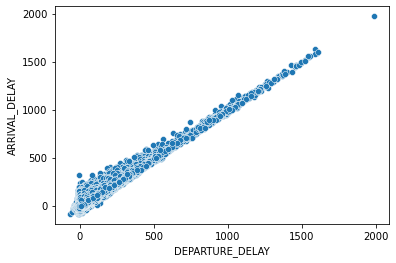

In [8]:
aux = flights_train
sns.scatterplot(aux.DEPARTURE_DELAY, aux.ARRIVAL_DELAY)

In [ ]:
sns.pairplot(flights_train.loc[:,"AIRLINE":].sample(100))

In [ ]:
_deepnote_run_altair(flights_train, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"line","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"SCHEDULED_DEPARTURE","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"DEPARTURE_TIME","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"MONTH","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}}}}""")

In [ ]:
flights_train.describe()

In [ ]:
# Scheduled_departure = hhmm
# Departure_time = hhmm
# Taxi_out = m (wheels_off - departure_time)
# Wheels_off = hhmm
# Scheduled_time = m
# Distance = km
# Scheduled_arrival = hhmm
# Arrival_delay = m


# corplot to see correlations between features (perhaps dimension reduction?)
# Random Forest
# Deep learning

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3bc7d17b-1023-4c90-8547-80a861833ae0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>